In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('data/FireStatLA/UCLA Heat Days - Daily Incident Summary.csv', parse_dates=['Incident Date'])

df.head()

,Incident Date,FSDistrict,IncidentCategory,IncidentCount
0,2018-01-01,1,AUTOMOBILE,1
1,2018-01-01,1,BURNS,1
2,2018-01-01,1,CHEST DISCOMFORT/HEART PROBLEM,1
3,2018-01-01,1,DIABETIC,1
4,2018-01-01,1,FALL,2


In [5]:
df.tail()

,Incident Date,FSDistrict,IncidentCategory,IncidentCount
1475661,2022-12-31,109,TRAFFIC,1
1475662,2022-12-31,112,ASSAULT,1
1475663,2022-12-31,112,CHEST DISCOMFORT/HEART PROBLEM,1
1475664,2022-12-31,112,FALL,3
1475665,2022-12-31,112,O.D./POISONING,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475666 entries, 0 to 1475665
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Incident Date     1475666 non-null  datetime64[ns]
 1   FSDistrict        1475666 non-null  int64         
 2   IncidentCategory  1474711 non-null  object        
 3   IncidentCount     1475666 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 45.0+ MB


In [7]:
df.IncidentCategory.unique()

array(['AUTOMOBILE', 'BURNS', 'CHEST DISCOMFORT/HEART PROBLEM',
       'DIABETIC', 'FALL', 'INTERFACILITY TRANSFER', 'O.D./POISONING',
       'RUBBISH', 'TRAFFIC', 'TREE', 'UNCONSCIOUS/FAINTING',
       'UNKNOWN PROBLEM', 'PEDIATRICS', 'SICK', 'STRUCTURE',
       'WATER-RELATED', 'ABDOMINAL', 'ASSAULT', 'AUTOMATIC ALARM',
       'CHEMICAL', 'SEIZURE', 'STABBING', 'STROKE', 'TOXIC',
       'PSYCH/SA/EMOTIONAL', 'BREATHING DIFFICULTY', 'INJURY', 'ELEVATOR',
       'BLEEDING (NON-TRAUMATIC)', 'SMOKE DETECTOR', 'GRASS',
       'ALLERGY/ENVENOMATION', 'CARDIAC/RESP. ARREST', 'CHOKING',
       'ANIMAL BITE', 'LOCKOUT', 'ELECTRICAL', 'BELLS RINGING',
       'SHOOTING', 'OB/GYN', 'SMOKE', 'STRUCTURE-AA', 'VEHICULAR', 'POLE',
       'HEADACHE', 'OVEN', 'BRUSH', 'H/C EXPOSURE', 'WATER FLOW',
       'BACK PAIN', 'HELP', 'TRANSFORMER', 'JUMPER', 'ELECTROCUTION',
       'AIRCRAFT', 'TOXIC EXPOSURE', 'INFECTIOUS DISEASE', 'CLIFF/HIKER',
       'DEBRIS', 'BOAT', 'BURN', 'BRUSHAA', 'TAR', 'METRO EL', 

In [8]:
ems_codes = pd.read_csv('data/FireStatLA/EMS Codes.csv')
ems_codes = ems_codes.melt() # creates 'long' dataframe of all ems values
ems_codes.dropna(inplace=True) #get rid of extra na values
ems_codes.rename(columns={'value': 'EMS', 'variable': 'severity'}, inplace=True) # renames columns to more intuitive names

ems_codes.head()

,severity,EMS
0,AHR,ABDOMINAL
1,AHR,ALLERGY/ENVENOMATION
2,AHR,ANIMAL BITE
3,AHR,ASSAULT
4,AHR,BLEEDING(NON-TRAUMATIC)


In [9]:
ems_df = df[df['IncidentCategory'].isin(ems_codes['EMS'])]
ems_df.head()

,Incident Date,FSDistrict,IncidentCategory,IncidentCount
1,2018-01-01,1,BURNS,1
2,2018-01-01,1,CHEST DISCOMFORT/HEART PROBLEM,1
3,2018-01-01,1,DIABETIC,1
4,2018-01-01,1,FALL,2
5,2018-01-01,1,INTERFACILITY TRANSFER,1


I think the next step here will be to group by date and FS district with the aggregation being a sum of Incident Count, since it seems like that is the volume for the day in that district.

In [10]:
print('The number of EMS records is: {}'.format(len(ems_df)))
print('The number of individual EMS calls is: {}'.format(ems_df['IncidentCount'].sum()))

The number of EMS records is: 1095001
The number of individual EMS calls is: 1679765


In [11]:
# i deleted the column FSDistrict in the beggining just to not be displayed in the result , then i applied the groupby function
#on the columns date and incident category to show for each day which accident category occured

res = df.drop('FSDistrict', axis=1).groupby(["Incident Date",'IncidentCategory']).sum()

In [28]:
ems_df.to_csv('data/FireStatLA/ems_with_categories.csv', index=False)

In [31]:
ems_counts_df = ems_df.groupby(['FSDistrict', 'Incident Date']).sum().reset_index()

<ipython-input-31-8f77c45d80d5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ems_counts_df = ems_df.groupby(['FSDistrict', 'Incident Date']).sum().reset_index()


In [33]:
ems_counts_df['IncidentCount'].describe()

count    178052.000000
mean          9.434126
std           7.254822
min           1.000000
25%           4.000000
50%           8.000000
75%          12.000000
max          66.000000
Name: IncidentCount, dtype: float64

This is very interesting, the max value feels like it comes out of nowhere, and at least without in relation to the whole system the standard deviation is very wide. That said we haven't accounted for the deviation within a given fire district within a given day. What is going on with that max value though? Let's take a look.

In [34]:
ems_counts_df.query('IncidentCount == 66')

,FSDistrict,Incident Date,IncidentCount
14859,9,2019-06-04,66
14920,9,2019-08-04,66


Hmmm, so there are two days, in the same district that had 66 incidents. Let's go back to the disagregated dataframe to see what types of incidents these are.

In [44]:
ems_df[(ems_df['Incident Date']=='2019-08-04') & (ems_df['FSDistrict']==9)]

,Incident Date,FSDistrict,IncidentCategory,IncidentCount
863500,2019-08-04,9,ABDOMINAL,3
863501,2019-08-04,9,ALLERGY/ENVENOMATION,2
863502,2019-08-04,9,ASSAULT,7
863505,2019-08-04,9,BREATHING DIFFICULTY,2
863506,2019-08-04,9,CHEST DISCOMFORT/HEART PROBLEM,5
863507,2019-08-04,9,DIABETIC,2
863508,2019-08-04,9,FALL,1
863509,2019-08-04,9,H/C EXPOSURE,1
863510,2019-08-04,9,HEADACHE,1
863511,2019-08-04,9,INJURY,5


Intersting, there are a lot of incidents in a lot of categories, but no apparent data problems, just a very active fire district. Maybe this area is in downtown or another very dense neighborhood? Let's take a look at the general distribution of call volumes in this district.

<Axes: >

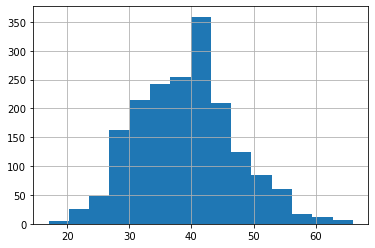

In [49]:
ems_counts_df[ems_counts_df['FSDistrict']==9]['IncidentCount'].hist(bins=15)

Fascinating. This district just has a very high volume of calls, but it follows something aproximating a normal distribution, it just has a higher volume overall. I suppose this is why we need to adjust our expected volume by fire district. We can also take a look at the descriptive statistics for the number of calls per day for each fire district. 

In [54]:
ems_counts_df.groupby('FSDistrict').describe()

IncidentCount                                                  
                   count       mean       std  min   25%   50%   75%   max
FSDistrict                                                                
1                 1825.0   7.275068  2.754374  1.0   5.0   7.0   9.0  17.0
2                 1826.0  10.594195  3.432983  1.0   8.0  10.0  13.0  25.0
3                 1826.0  11.760679  3.742713  1.0   9.0  12.0  14.0  25.0
4                 1826.0  16.087076  4.688029  3.0  13.0  16.0  19.0  34.0
5                 1817.0   5.565768  2.436008  1.0   4.0   5.0   7.0  16.0
...                  ...        ...       ...  ...   ...   ...   ...   ...
108                669.0   1.270553  0.568681  1.0   1.0   1.0   1.0   5.0
109               1337.0   1.783096  0.966156  1.0   1.0   2.0   2.0   6.0
110                 77.0   1.012987  0.113961  1.0   1.0   1.0   1.0   2.0
111                242.0   1.123967  0.387999  1.0   1.0   1.0   1.0   3.0
112               1776.0   3.826577  1.946985  1.0   2.0   4.0   5.0  13.0

[104 rows x 8 columns]

In [58]:
len(ems_counts_df['FSDistrict'].unique())

104

Some things to note are that there are a handful of districts that have had days with no calls (shown by inconsistent "counts"). In this data, absence of a day indicates the lack of calls on that day.

We also should expect to see 102 fire districts based on the shape file available on the city website, when we join the data together we should explore which districts don't match up and see if we can figure out why. 

When I look online the current LAFD "First In" districts show 106 records but the split districts we had in the fire station district file were disolved, so using that version may solve the problem.

In [ ]:
ems_counts_df.to_csv('data/FireStatLA/ems_call_counts.csv', index=False)